In [1]:
import sympy
from sympy.abc import X, B, C, D     # Establish our variable names
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
%matplotlib inline

In [3]:
def interpolate(conds):
    """
    Finds the polynomial of minimal degree that solves the given Hermite conditions.

    conds is a list of the form
      [(x1, r1, v1), (x2, r2, v2), ...]
    where the polynomial p is to satisfy p^(r_1) (x_1) = v_1, and so on.
    """
    # the degree will be one less than the number of conditions
    n = len(conds)

    # generate a symbol for each coefficient
    A = [sympy.Symbol("a[%d]" % i) for i in range(n)]

    # generate the desired polynomial symbolically
    P = sum([A[i] * X**i for i in range(n)])

    # generate the equations the polynomial must satisfy
    #
    # for each (x, r, v), sympy evaluates the rth derivative of P wrt X,
    # substitutes x in for X, and requires that this equals v.
    EQNS = [sympy.diff(P, X, r).subs(X, x) - v for x, r, v in conds]

    # solve this system.
    SOLN = sympy.solve(EQNS, A)

    return P.subs(SOLN)


In [4]:
interpolate([(1, 0, 1), (1, 1, 2)])

2*X - 1

In [5]:
# We fix the values of a0, b0, c0.
a0 = 0
b0 = 3
c0 = 1

# We require p(a0) = 0, p(b0) = 0, p(c0) = 1, p'(c0) = 0.
BASIC_CONDS = [(a0, 0, 0), (b0, 0, 0), (c0, 0, 1), (c0, 1, 0)]

def c_degen(n, residue):
    """
    Give Hermite conditions for order of vanishing at c0 equal to `n`, with
    first nonzero residue `residue`.

    NOTE: the order `n` is in terms of f', not of f. That is, this is the amount
    of additional degeneracy to add.  This may be a source of off-by-one errors.
    """
    return [(c0, 1 + i, 0) for i in range(1, n + 1)] + [(c0, n + 2, residue)]


def b_degen(n, residue):
    """
    Give Hermite conditions for order of vanishing at b0 equal to `n`, with
    first nonzero residue `residue`.
    """
    return [(b0, i, 0) for i in range(1, n + 1)] + [(b0, n + 1, residue)]

def poly_with_degens(nc=0, nb=0, residue_c=3, residue_b=3):
    """
    Give unique polynomial with given degeneracies for this MVT problem.

    `nc` is the order of vanishing of f' at c0, with first nonzero residue `residue_c`.
    `nb` is the order of vanishing of f at b0, with first nonzero residue `residue_b`.
    """
    conds = BASIC_CONDS + c_degen(nc, residue_c) + b_degen(nb, residue_b)
    return interpolate(conds)

In [6]:
poly_with_degens()

11*X**5/16 - 21*X**4/4 + 113*X**3/8 - 65*X**2/4 + 123*X/16

In [7]:
def smoother_interpolate(conds, ctrl_point=2, order=1, interval=(0,4)):
    """
    Find the polynomial of minimal degree that interpolates the Hermite
    conditions in `conds`, and whose behavior at `ctrl_point` minimizes the L2
    norm on `interval` of its derivative.
    """
    # Add the symbolic point to the conditions.
    # Recall that D is a sympy variable
    new_conds = conds + [(ctrl_point, order, D)]

    # Find the polynomial interpolating `new_conds`, symbolic in X *and* D
    P = interpolate(new_conds)

    # Compute L2 norm of the derivative on `interval`
    L2 = sympy.integrate(sympy.diff(P, X)**2, (X, *interval))

    # Take the first critical point of the L2 norm with respect to D
    SOLN = sympy.solve(sympy.diff(L2, D), D)[0]

    # Substitute the minimizing solution in for D and return
    return P.subs(D, SOLN)


def smoother_poly_with_degens(nc=0, nb=0, residue_c=3, residue_b=3):
    """
    Give unique polynomial with given degeneracies for this MVT problem whose
    derivative on (0, 4) has minimal L2 norm.

    `nc` is the order of vanishing of f' at c0, with first nonzero residue `residue_c`.
    `nb` is the order of vanishing of f at b0, with first nonzero residue `residue_b`.

    """
    conds = BASIC_CONDS + c_degen(nc, residue_c) + b_degen(nb, residue_b)
    return smoother_interpolate(conds)


In [8]:
sympy.N(smoother_poly_with_degens())

-0.290763858423069*X**6 + 3.30437472580762*X**5 - 13.9729157526921*X**4 + 27.5001374874612*X**3 - 25.8452073279613*X**2 + 10.3043747258076*X

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def basic_plot(F, n=300, outfile="basic_plot.pdf"):
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(1, 1, 1)
    b1d = np.linspace(-0.5, 4.5, n)
    f = sympy.lambdify(X, F)(b1d)
    ax.plot(b1d,f,'k')
    ax.set_aspect('equal')
    ax.grid(True)
    ax.set_xlim([-.5, 4.5])
    ax.set_ylim([-1, 5])
    ax.plot([0, c0, b0],[0, F.subs(X,c0),F.subs(X,b0)],'ko')
    fig.savefig(outfile, bbox_inches='tight')

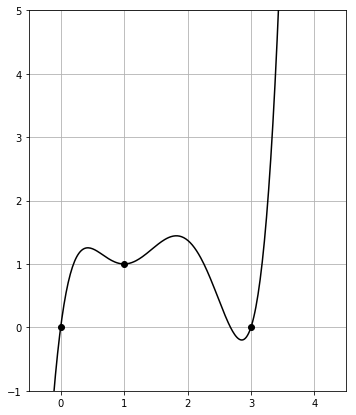

In [10]:
Fbasic = poly_with_degens()
basic_plot(Fbasic, outfile="basic_plot_one.png")

In [11]:
interval = (0, 4)
sympy.N(sympy.integrate(sympy.diff(poly_with_degens(), X)**2, (X, *interval)))

1865.15411706349

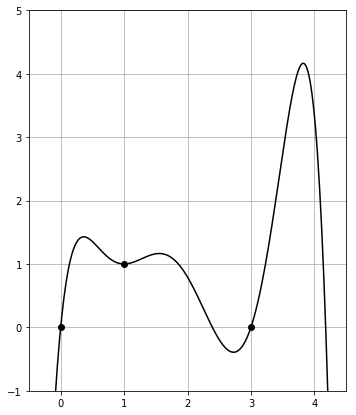

In [12]:
Fsmooth_basic = smoother_poly_with_degens()
basic_plot(Fsmooth_basic, outfile="basic_plot_two.png")

In [13]:
interval = (0, 4)
sympy.N(sympy.integrate(sympy.diff(smoother_poly_with_degens(), X)**2, (X, *interval)))

41.1612799050325

In [14]:
def abscissa_plot(F, n=300, outfile="abscissa_plot.pdf"):
    # Compute the derivative of f
    DF = sympy.diff(F,X)

    # Define CAP_F --- "capital F"
    #
    # this is (f(b) - f(0))/(b - 0) - f'(c).
    CAP_F = (F.subs(X, B) - F.subs(X, 0)) / (B - 0) - DF.subs(X, C)

    # build the mesh
    b1d = np.linspace(-.5, 4.5, n)
    b2d, c2d = np.meshgrid(b1d, b1d)

    # compute CAP_F within the mesh
    cap_f_mesh = sympy.lambdify((B, C), CAP_F)(b2d, c2d)

    # restrict attention to below the diagonal --- we require c < b
    # (although the mas inequality looks reversed in this perspective)
    valid_cap_f_mesh = scipy.ma.array(cap_f_mesh, mask=c2d>b2d)

    # Set up plot basics
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_aspect('equal')
    ax.grid(True)
    ax.set_xlim([-.5, 4.5])
    ax.set_ylim([-.5, 4.5])

    # plot the contour
    ax.contour(b2d, c2d, valid_cap_f_mesh, [0], colors='k')

    # plot a diagonal line representing the boundary
    ax.plot(b1d,b1d,'k--')

    # plot the guaranteed point
    ax.plot(b0,c0,'ko')

    fig.savefig(outfile, bbox_inches="tight")

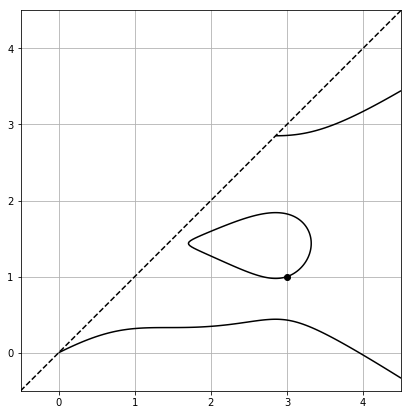

In [15]:
abscissa_plot(Fbasic, outfile="abs_plot_one.png")

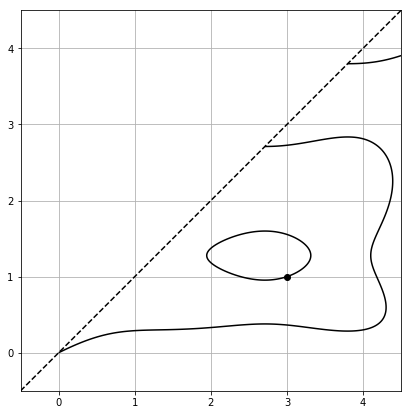

In [16]:
abscissa_plot(Fsmooth_basic, outfile="abs_plot_two.png")

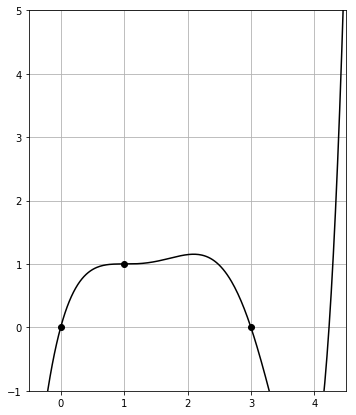

In [17]:
F3 = smoother_poly_with_degens(nc=1, residue_b=-3)
basic_plot(F3, outfile="basic_plot_F3.png")

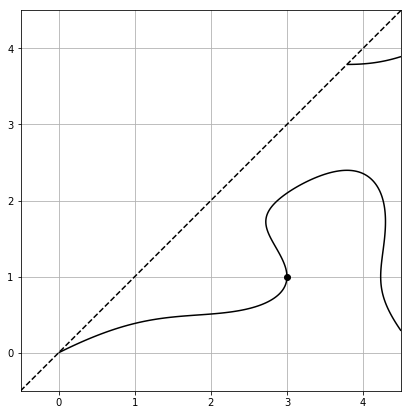

In [18]:
abscissa_plot(F3, outfile="abs_plot_f3.png")